# Estimating photometric redshifts with RAIL stages and comparing results for different parameters

**Authors:** Jennifer Scora

**Last run successfully:** Jan 27, 2025

This notebook shows how to run through the various stages of RAIL (creation, estimation, evaluation) in order to create a simulated dataset of galaxy magnitudes and redshifts, use the magnitudes to estimate photometric redshifts, and then compare the resulting estimated photometric redshifts to the *true* redshifts. We will be using the `k-Nearest Neighbours` algorithm (for more information on this algorithm see here link) to estimate redshifts, and testing out how the limits on the number of nearest neighbours affect the resulting esimated redshift distributions. To do this, we loop over the estimation and evaluation stages while varying these parameters to test their effect. We will also then be exploring how we can parallelize this loop within the notebook to speed things up a little. However, if you are running on very large datasets, we recommend running in pipeline mode instead (link), as it is not possible to loop over large files with the interactive mode of RAIL. 

Here are the steps that we're going to cover in this notebook:

1. Creating a realistic data set of galaxy magnitudes and true redshifts 
2. Estimating the photometric redshifts
3. Summarizing the redshift distributions
4. Evaluating the photometric redshifts against the *true* values
5. Comparing the resulting redshift distributions
6. Repeating steps 2-5 with a parallelized loop

## 1. Creating a realistic data set of galaxy magnitudes and true redshifts

First we want to create the data sets of galaxy magnitudes that we will use to estimate photometric redshifts. We will use PZflow to generate our model, and then pull two data sets from the model, a training dataset and a test dataset. The training data set will be used to train our models, and the test data set is the data we will get photo-z estimates for. We'll then degrade these datasets so that they better resemble real data from the Rubin telescope. 

In [ ]:
# import the packages we'll need 
import rail.interactive as ri 
import numpy as np
import tables_io
from pzflow.examples import get_galaxy_data

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


LEPHAREDIR is being set to the default cache directory:
/home/jscora/.cache/lephare/data
More than 1Gb may be written there.
LEPHAREWORK is being set to the default cache directory:
/home/jscora/.cache/lephare/work
Default work cache is already linked. 
This is linked to the run directory:
/home/jscora/.cache/lephare/runs/20250327T165906


Here we first need to set up some column name dictionaries, as the expected column names vary between some of the codes. In order to handle this, we can pass in a dictionary of expected column names and the column name that exists in the input data. In this case, our data will have column names for 

In [3]:
bands = ["u", "g", "r", "i", "z", "y"]
band_dict = {band: f"mag_{band}_lsst" for band in bands}
rename_dict = {f"mag_{band}_lsst_err": f"mag_err_{band}_lsst" for band in bands}

We also need to grab the data to use for training the flow engine.

In [4]:
catalog = get_galaxy_data().rename(band_dict, axis=1)

### Train and sample the model

Here we need to train the normalizing flow that serves as the engine for the input data creation, and then use the flow to produce some synthetic data for our training data set, as well as for our test data set. We will create small datasets of 150 galaxies each for this example.

In [5]:
flow_model = ri.creation.engines.flowEngine.flow_modeler(
    input=catalog,
    seed=0,
    phys_cols={"redshift": [0, 3]},
    phot_cols={
        "mag_u_lsst": [17, 35],
        "mag_g_lsst": [16, 32],
        "mag_r_lsst": [15, 30],
        "mag_i_lsst": [15, 30],
        "mag_z_lsst": [14, 29],
        "mag_y_lsst": [14, 28],
    },
    calc_colors={"ref_column_name": "mag_i_lsst"},
)

# get sample test and training data sets
train_data_orig = ri.creation.engines.flowEngine.flow_creator(
    n_samples=150, model=flow_model["model"], seed=1235
)
test_data_orig = ri.creation.engines.flowEngine.flow_creator(
    model=flow_model["model"], n_samples=150, seed=1234
)

Inserting handle into data store.  input: None, FlowModeler
Training 30 epochs 
Loss:
(0) 21.3266
(1) 3.9686
(2) 1.9351
(3) 5.2006
(4) -0.3579
(5) 2.2561
(6) 1.5917
(7) 0.3691
(8) -1.0218
(9) inf
Training stopping after epoch 9 because training loss diverged.
Inserting handle into data store.  model: inprogress_model.pkl, FlowModeler
Inserting handle into data store.  model: <pzflow.flow.Flow object at 0x71154c0d5610>, FlowCreator
Inserting handle into data store.  output: inprogress_output.pq, FlowCreator
Inserting handle into data store.  model: <pzflow.flow.Flow object at 0x71154c0d5610>, FlowCreator
Inserting handle into data store.  output: inprogress_output.pq, FlowCreator


### Degrade the data sets

Next we will apply some degradation functions to the data, to make it look more like real observations. We apply the following functions to the training data set:
1. `LSSTErrorModel` to add photometric errors 
2. `InvRedshiftIncompleteness` to remove some galaxies above a redshift threshold
3. `LineConfusion` to simulate the effect of misidentified lines 
4. `QuantityCut`cuts galaxies based on their specific band magnitudes 

We then use `ColumnMapper` to rename the error columns so that they match the names in DC2, and use `TableConverter` to convert the data to a numpy dictionary, so that it fits the expected input format for the following functions. 

For the test data set, we only apply the `LSSTErrorModel` degradations, as well as making the above structural changes to get the data in the same output format as the training data set.

In [6]:
### degrade training data
# add photometric errors modelled on LSST to the data
train_data_errs = ri.creation.degraders.photometric_errors.lsst_error_model(
    input=train_data_orig["output"], seed=66, renameDict=band_dict, ndFlag=np.nan
)
# randomly removes some galaxies above certain redshift threshold 
train_data_inc = (
    ri.creation.degraders.spectroscopic_degraders.inv_redshift_incompleteness(
        input=train_data_errs["output"], pivot_redshift=1.0
    )
)
# simulates the effect of misidentified lines 
train_data_conf = ri.creation.degraders.spectroscopic_degraders.line_confusion(
    input=train_data_inc["output"],
    true_wavelen=5007.0,
    wrong_wavelen=3727.0,
    frac_wrong=0.05,
    seed=1337,
)
# cut some of the data below a certain magnitude 
train_data_cut = ri.creation.degraders.quantityCut.quantity_cut(
    input=train_data_conf["output"], cuts={"mag_i_lsst": 25.0}
)
# renames error columns to match DC2
train_data_pq = ri.tools.table_tools.column_mapper(
    input=train_data_cut["output"], columns=rename_dict
)
# converts output to a numpy dictionary
train_data = ri.tools.table_tools.table_converter(
    input=train_data_pq["output"], output_format="numpyDict"
)

### degrade testing data
# add photometric errors modelled on LSST to the data
test_data_errs = ri.creation.degraders.photometric_errors.lsst_error_model(
    input=test_data_orig["output"], seed=58, renameDict=band_dict, ndFlag=np.nan
)
# renames error columns to match DC2
test_data_pq = ri.tools.table_tools.column_mapper(
    input=test_data_errs["output"], columns=rename_dict, hdf5_groupname=""
)
# converts output to a numpy dictionary
test_data = ri.tools.table_tools.table_converter(
    input=test_data_pq["output"], output_format="numpyDict"
)


Inserting handle into data store.  input: None, LSSTErrorModel
Inserting handle into data store.  output: inprogress_output.pq, LSSTErrorModel
Inserting handle into data store.  input: None, InvRedshiftIncompleteness
Inserting handle into data store.  output: inprogress_output.pq, InvRedshiftIncompleteness
Inserting handle into data store.  input: None, LineConfusion
Inserting handle into data store.  output: inprogress_output.pq, LineConfusion
Inserting handle into data store.  input: None, QuantityCut
Inserting handle into data store.  output: inprogress_output.pq, QuantityCut
Inserting handle into data store.  input: None, ColumnMapper
Inserting handle into data store.  output: inprogress_output.pq, ColumnMapper
Inserting handle into data store.  input: None, TableConverter
Inserting handle into data store.  output: inprogress_output.hdf5, TableConverter
Inserting handle into data store.  input: None, LSSTErrorModel
Inserting handle into data store.  output: inprogress_output.pq, LS

In [7]:
test_data_orig["output"]

,redshift,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst
0,0.103872,22.906694,22.358709,21.818205,21.559589,21.555933,21.550838
1,0.456719,24.310820,23.649132,22.753054,22.370310,22.215559,22.098450
2,0.525806,24.664982,23.604193,22.261162,21.590563,21.268764,20.928415
3,0.541941,27.791058,27.086382,26.021805,25.579063,25.383804,25.238136
4,2.028277,27.788912,27.515602,26.852974,26.420877,25.675110,25.132336
...,...,...,...,...,...,...,...
145,0.813532,27.373718,26.486151,25.334875,24.198498,23.775885,23.441877
146,0.534561,24.474289,23.788475,22.671724,22.012754,21.821472,21.594889
147,0.964489,24.562754,24.564314,24.512400,24.182508,23.758638,23.717516
148,2.066555,26.127260,26.234278,26.086443,26.059875,25.952612,25.536114


In [8]:
len(test_data["output"]["redshift"])

150

## Estimate the redshifts and evaluate performance

Now, we estimate our photometric redshifts. We use the [K-Nearest Neighbour algorithm](https://rail-hub.readthedocs.io/en/latest/source/estimators.html#k-nearest-neighbor) to estimate our redshifts, varying the minimum and maximum allowed number of neighbours to see its effect on the final result. To do this, we iterate over a list of the different parameter inputs we want to use for the estimator. In each loop, we:
- estimate the redshifts with the chosen parameters
- summarize the distribution of redshifts using the Naive Stacking and Point Estimate Histogram methods
- evaluate how the estimated redshifts compare to the true redshifts (the original test data set before degradation)
- save the evaluation results and summarized distributions to dictionaries so we can access them outside the loop


In [9]:
### Iterate over estimating photo-zs using KNN 

# set up parameters to iterate over and dictionaries to store data
nb_params = [(3,7), (2,6), (2,8), (4,9)]
eval_dict = {}
naive_dict = {}
point_est_dict = {}

for nb_min, nb_max in nb_params:
    # train the informer
    inform_knn = ri.estimation.algos.k_nearneigh.k_near_neig_informer(
        input=train_data["output"], nondetect_val=np.nan, model="bpz.pkl", hdf5_groupname="", nneigh_min=nb_min, nneigh_max=nb_max
    )
    # get photo-zs
    knn_estimated = ri.estimation.algos.k_nearneigh.k_near_neig_estimator(
        input=test_data["output"],
        model=inform_knn["model"],
        nondetect_val=np.nan,
        hdf5_groupname="",
    )

    ### Evaluate the results 
    evaluator_stage_dict = dict(
        metrics=["cdeloss", "pit", "brier"],
        _random_state=None,
        metric_config={
            "brier": {"limits": (0, 3.1)},
            "pit": {"tdigest_compression": 1000},
        },
    )
    truth = test_data_orig

    the_eval = ri.evaluation.dist_to_point_evaluator.dist_to_point_evaluator(
            input={"data": knn_estimated["output"], "truth": truth["output"]
            },
            **evaluator_stage_dict,
            hdf5_groupname="",
        )
    
    # put the evaluation results in a dictionary so we have them 
    eval_dict[(nb_min,nb_max)] = the_eval

    # summarize the distributions using point estimate and naive stack summarizers 
    point_estimate_ens = ri.estimation.algos.point_est_hist.point_est_hist_summarizer(
    input=knn_estimated["output"]
    )
    point_est_dict[(nb_min,nb_max)] = point_estimate_ens
    naive_stack_ens = ri.estimation.algos.naive_stack.naive_stack_summarizer(
        input=knn_estimated["output"]
    )
    naive_dict[(nb_min,nb_max)] = naive_stack_ens





Inserting handle into data store.  input: None, KNearNeighInformer
split into 49 training and 16 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.075 and numneigh=3



Inserting handle into data store.  model: inprogress_bpz.pkl, KNearNeighInformer
Inserting handle into data store.  input: None, KNearNeighEstimator
Inserting handle into data store.  model: {'kdtree': <sklearn.neighbors._kd_tree.KDTree object at 0x649c57ee61f0>, 'bestsig': np.float64(0.075), 'nneigh': 3, 'truezs': array([0.8559624 , 1.09725535, 0.67563593, 0.91550589, 0.90324795,
       0.65226948, 0.77357709, 0.37648416, 1.22105432, 0.89333856,
       0.65628129, 0.83754033, 1.04881907, 1.19360622, 0.41372049,
       1.24091506, 0.07890534, 0.33354044, 0.84880698, 0.50793141,
       0.07312357, 0.92710775, 0.53522396, 0.78664237, 0.55667555,
       0.45270801, 0.50885946, 1.21598339, 0.55211103, 0.22890699,
       0.49027538, 0.60366631, 0.66702271, 0.59513855, 1.08075809,
       1

Inserting handle into data store.  input: None, DistToPointEvaluator
Inserting handle into data store.  truth: None, DistToPointEvaluator
Requested metrics: ['cdeloss', 'pit', 'brier']
Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 150
Inserting handle into data store.  output: inprogress_output.hdf5, PointEstHistSummarizer
Inserting handle into data store.  single_NZ: inprogress_single_NZ.hdf5, PointEstHistSummarizer
Inserting handle into data store.  input: None, NaiveStackSummarizer
Process 0 running estimator on chunk 0 - 150
Inserting handle into data store.  output: inprogress_output.hdf5, NaiveStackSummarizer
Ins

Inserting handle into data store.  input: None, DistToPointEvaluator
Inserting handle into data store.  truth: None, DistToPointEvaluator
Requested metrics: ['cdeloss', 'pit', 'brier']
Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 150
Inserting handle into data store.  output: inprogress_output.hdf5, PointEstHistSummarizer
Inserting handle into data store.  single_NZ: inprogress_single_NZ.hdf5, PointEstHistSummarizer
Inserting handle into data store.  input: None, NaiveStackSummarizer
Process 0 running estimator on chunk 0 - 150
Inserting handle into data store.  output: inprogress_output.hdf5, NaiveStackSummarizer
Ins

Inserting handle into data store.  input: None, DistToPointEvaluator
Inserting handle into data store.  truth: None, DistToPointEvaluator
Requested metrics: ['cdeloss', 'pit', 'brier']
Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 150
Inserting handle into data store.  output: inprogress_output.hdf5, PointEstHistSummarizer
Inserting handle into data store.  single_NZ: inprogress_single_NZ.hdf5, PointEstHistSummarizer
Inserting handle into data store.  input: None, NaiveStackSummarizer
Process 0 running estimator on chunk 0 - 150
Inserting handle into data store.  output: inprogress_output.hdf5, NaiveStackSummarizer
Ins

Inserting handle into data store.  input: None, DistToPointEvaluator
Inserting handle into data store.  truth: None, DistToPointEvaluator
Requested metrics: ['cdeloss', 'pit', 'brier']
Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 150
Inserting handle into data store.  output: inprogress_output.hdf5, PointEstHistSummarizer
Inserting handle into data store.  single_NZ: inprogress_single_NZ.hdf5, PointEstHistSummarizer
Inserting handle into data store.  input: None, NaiveStackSummarizer
Process 0 running estimator on chunk 0 - 150
Inserting handle into data store.  output: inprogress_output.hdf5, NaiveStackSummarizer
Ins

In [10]:
point_est_dict[(3,7)]

{'output': Ensemble(the_class=hist,shape=(1000, 301)),
 'single_NZ': Ensemble(the_class=hist,shape=(1, 301))}

In [11]:
point_est_dict[(3,7)]['single_NZ']

Ensemble(the_class=hist,shape=(1, 301))

## Compare the results

We can take a look at the evaluation metrics that we've generated for each of the runs to see how they compare 

In [12]:
# TODO: either make this into a nicer table or just print out the dictionary?
results_tables = {
    key: tables_io.convertObj(val["summary"], tables_io.types.PD_DATAFRAME)
    for key, val in eval_dict.items()
}
results_tables

{(3,
  7):     cdeloss       brier
 0 -0.291637  207.562705,
 (2,
  6):     cdeloss       brier
 0 -0.291637  207.562705,
 (2,
  8):     cdeloss       brier
 0 -0.291637  207.562705,
 (4,
  9):     cdeloss       brier
 0 -0.455857  181.257479}

In [13]:
eval_dict

{(3, 7): {'output': {},
  'summary': {'cdeloss': array([-0.29163656]), 'brier': array([207.56270501])},
  'single_distribution_summary': {'pit': Ensemble(the_class=quant,shape=(1, 89))}},
 (2, 6): {'output': {},
  'summary': {'cdeloss': array([-0.29163656]), 'brier': array([207.56270501])},
  'single_distribution_summary': {'pit': Ensemble(the_class=quant,shape=(1, 89))}},
 (2, 8): {'output': {},
  'summary': {'cdeloss': array([-0.29163656]), 'brier': array([207.56270501])},
  'single_distribution_summary': {'pit': Ensemble(the_class=quant,shape=(1, 89))}},
 (4, 9): {'output': {},
  'summary': {'cdeloss': array([-0.45585671]), 'brier': array([181.25747914])},
  'single_distribution_summary': {'pit': Ensemble(the_class=quant,shape=(1, 88))}}}

We can also plot the summarized distributions of all the photometric redshifts generated in a loop against each other, to compare the effect of the different parameters. Below, we plot the runs with the following parameters, since they have the most different evaluation metrics: 
- minimum neighbours: 3, maximum neighbours: 7
- minimum neighbours: 4, maximum neighbours: 9

Text(0, 0.5, 'p(z)')

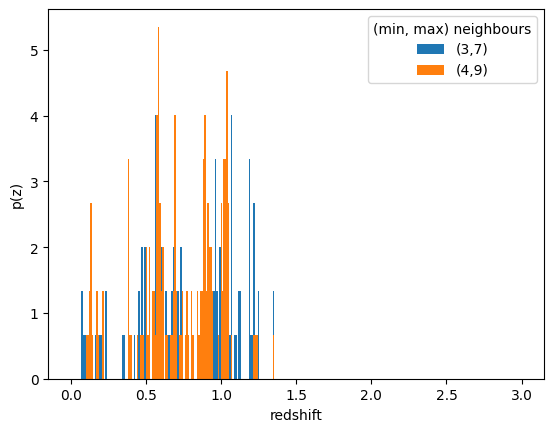

In [26]:
import matplotlib.pyplot as plt 
%matplotlib inline

# get bin centers and widths 
bin_width = point_est_dict[(3,7)]["single_NZ"].metadata["bins"][1] - point_est_dict[(3,7)]["single_NZ"].metadata["bins"][0]
bin_centers = (point_est_dict[(3,7)]["single_NZ"].metadata["bins"][:-1] + point_est_dict[(3,7)]["single_NZ"].metadata["bins"][1:])/2

# plot both histograms to compare
plt.bar(bin_centers,point_est_dict[(3,7)]["single_NZ"].objdata["pdfs"],width=bin_width,label="(3,7)")
plt.bar(bin_centers,point_est_dict[(4,9)]["single_NZ"].objdata["pdfs"],width=bin_width,label="(4,9)")
plt.legend(loc="best", title="(min, max) neighbours")
plt.xlabel("redshift")
plt.ylabel("p(z)")

Text(0, 0.5, 'p(z)')

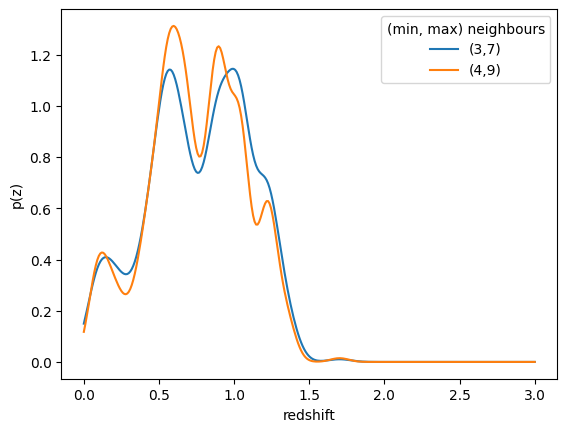

In [28]:
# Plot of naive stack summarized distribution 
plt.plot(naive_dict[(3,7)]["single_NZ"].metadata["xvals"], naive_dict[(3,7)]["single_NZ"].objdata["yvals"],label="(3,7)")
plt.plot(naive_dict[(4,9)]["output"].metadata["xvals"], naive_dict[(4,9)]["single_NZ"].objdata["yvals"],label="(4,9)")

plt.legend(loc="best", title="(min, max) neighbours")
plt.xlabel("redshift")
plt.ylabel("p(z)")

## Using multiprocessing

Let's say we wanted to do the same as above but with a lot more parameters (and perhaps with a slower algorithm). We can use the python `multiprocessing` module to run the whole loop concurrently, and speed up the process a little. To do this, we need to turn our loop above into its own function. 

In [ ]:
def estimate_photoz(nb_lims):
    """A function to estimate photo-zs using the KNN alorithm, given a minimum and maximum number of nearest neighbours. It will 
    then evaluate the performance """

    # nb_lims, train_data, test_data, inform_knn, test_data_orig = args[0], args[1][0], args[1][1], args[1][2]

    # train the informer
    inform_knn = ri.estimation.algos.k_nearneigh.k_near_neig_informer(
        input=train_data["output"], nondetect_val=np.nan, model="bpz.pkl", hdf5_groupname="", nneigh_min=nb_lims[0], nneigh_max=nb_lims[1]
    )
    # get photo-zs
    knn_estimated = ri.estimation.algos.k_nearneigh.k_near_neig_estimator(
        input=test_data["output"],
        model=inform_knn["model"],
        nondetect_val=np.nan,
        hdf5_groupname="",
    )
   
    ### Evaluate the results 
    evaluator_stage_dict = dict(
        metrics=["cdeloss", "pit", "brier"],
        _random_state=None,
        metric_config={
            "brier": {"limits": (0, 3.1)},
            "pit": {"tdigest_compression": 1000},
        },
    )
    truth = test_data_orig

    the_eval = ri.evaluation.dist_to_point_evaluator.dist_to_point_evaluator(
            input={"data": knn_estimated["output"], "truth": truth["output"]
            },
            **evaluator_stage_dict,
            hdf5_groupname="",
        )
    
    # put the evaluation results in a dictionary so we have them 
    # eval_dict_lg[(nb_lims[0],nb_lims[1])] = the_eval

    # summarize the distributions using point estimate and naive stack summarizers 
    point_estimate_ens = ri.estimation.algos.point_est_hist.point_est_hist_summarizer(
    input=knn_estimated["output"]
    )
    # point_est_dict_lg[(nb_lims[0],nb_lims[1])] = point_estimate_ens
    naive_stack_ens = ri.estimation.algos.naive_stack.naive_stack_summarizer(
        input=knn_estimated["output"]
    )
    # naive_dict_lg[(nb_lims[0],nb_lims[1])] = naive_stack_ens
    return nb_lims, the_eval, point_estimate_ens, naive_stack_ens

In [ ]:
from multiprocessing.pool import ThreadPool as Pool

# set up parameters to iterate over and dictionaries to store data
nb_params = [(3,7), (2,6), (2,8), (4,9), (5,10), (1,9), (2,9), (3,10)]
nb_mins = [3,2,2,4,5,1,2,3]
nb_maxs = [7,6,8,9,10,9,9,10]
eval_dict_lg = {}
naive_dict_lg = {}
point_est_dict_lg = {}

pool = Pool(4) # use 4 cores 
for result in pool.imap_unordered(estimate_photoz, nb_params):
    eval_dict_lg[result[0]] = result[1]
    point_est_dict_lg[result[0]] = result[2]
    naive_dict_lg[result[0]] = result[3]

Inserting handle into data store.  input: None, KNearNeighInformer
split into 48 training and 16 validation samples
finding best fit sigma and NNeigh...
Inserting handle into data store.  input: None, KNearNeighInformer
Inserting handle into data store.  input: None, KNearNeighInformer
split into 48 training and 16 validation samples
finding best fit sigma and NNeigh...
split into 48 training and 16 validation samples
finding best fit sigma and NNeigh...
Inserting handle into data store.  input: None, KNearNeighInformer
split into 48 training and 16 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.075 and numneigh=3



Inserting handle into data store.  model: inprogress_bpz.pkl, KNearNeighInformer
Inserting handle into data store.  input: None, KNearNeighEstimator
Inserting handle into data store.  model: {'kdtree': <sklearn.neighbors._kd_tree.KDTree object at 0x75e6ec080ba0>, 'bestsig': np.float64(0.075), 'nneigh': 3, 'truezs': array([0.8559624 ,

Inserting handle into data store.  input: None, DistToPointEvaluator
Inserting handle into data store.  truth: None, DistToPointEvaluator
Requested metrics: ['cdeloss', 'pit', 'brier']
Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 150


Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 150



best fit values are sigma=0.075 and numneigh=4



Inserting handle into data store.  model: inprogress_bpz.pkl, KNearNeighInformer
Inserting handle into data store.  input: None, KNearNeighEstimator
Inserting handle into data store.  model: {'kdtree': <sklearn.neighbors._kd_tree.KDTree object at 0x75e7740bcb20>, 'bestsig': np.float64(0.075), 'nneigh': 4, 'truezs': array([0.8559624 , 1.09725535, 0.67563593, 0.91550589, 0.90324795,
       0.65226948, 0.77357709, 0.37648416, 1.22105432, 0.89333856,
       0.65628129, 0.83754033, 1.04881907, 1.19360622, 0.41372049,
     

Inserting handle into data store.  input: None, DistToPointEvaluator
Inserting handle into data store.  truth: None, DistToPointEvaluator
Requested metrics: ['cdeloss', 'pit', 'brier']



best fit values are sigma=0.075 and numneigh=3



Inserting handle into data store.  model: inprogress_bpz.pkl, KNearNeighInformer
Inserting handle into data store.  input: None, KNearNeighEstimator
Inserting handle into data store.  model: {'kdtree': <sklearn.neighbors._kd_tree.KDTree object at 0x75e7600170d0>, 'bestsig': np.float64(0.075), 'nneigh': 3, 'truezs': array([0.8559624 , 1.09725535, 0.67563593, 0.91550589, 0.90324795,
       0.65226948, 0.77357709, 0.37648416, 1.22105432, 0.89333856,
       0.65628129, 0.83754033, 1.04881907, 1.19360622, 0.41372049,
       0.07890534, 0.33354044, 0.84880698, 0.50793141, 0.07312357,
       0.92710775, 0.53522396, 0.78664237, 0.55667555, 0.45270801,
       0.50885946, 1.21598339, 0.55211103, 0.22890699, 0.49027538,
       0.60366631, 0.66702271, 0.59513855, 

Inserting handle into data store.  output: inprogress_output.hdf5, KNearNeighEstimator
Inserting handle into data store.  input: None, DistToPointEvaluator
Inserting handle into data store.  truth: None, DistToPointEvaluator
Requested metrics: ['cdeloss', 'pit', 'brier']
Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 150
Inserting handle into data store.  output: inprogress_output.hdf5, PointEstHistSummarizer
Inserting handle into data store.  single_NZ: inprogress_single_NZ.hdf5, PointEstHistSummarizer
Inserting handle into data store.  input: None, NaiveStackSummarizer
Process 0 running estimator on chunk 0 - 150
Inse

Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 150



best fit values are sigma=0.075 and numneigh=3



Inserting handle into data store.  model: inprogress_bpz.pkl, KNearNeighInformer
Inserting handle into data store.  input: None, KNearNeighEstimator
Inserting handle into data store.  model: {'kdtree': <sklearn.neighbors._kd_tree.KDTree object at 0x75e780064c40>, 'bestsig': np.float64(0.075), 'nneigh': 3, 'truezs': array([0.8559624 , 1.09725535, 0.67563593, 0.91550589, 0.90324795,
       0.65226948, 0.77357709, 0.37648416, 1.22105432, 0.89333856,
       0.65628129, 0.83754033, 1.04881907, 1.19360622, 0.41372049,
     

Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 150



best fit values are sigma=0.075 and numneigh=3



Inserting handle into data store.  model: inprogress_bpz.pkl, KNearNeighInformer
Inserting handle into data store.  input: None, KNearNeighEstimator
Inserting handle into data store.  model: {'kdtree': <sklearn.neighbors._kd_tree.KDTree object at 0x75e76007a170>, 'bestsig': np.float64(0.075), 'nneigh': 3, 'truezs': array([0.8559624 , 1.09725535, 0.67563593, 0.91550589, 0.90324795,
       0.65226948, 0.77357709, 0.37648416, 1.22105432, 0.89333856,
       0.65628129, 0.83754033, 1.04881907, 1.19360622, 0.41372049,
     

Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 150



best fit values are sigma=0.075 and numneigh=3



Inserting handle into data store.  model: inprogress_bpz.pkl, KNearNeighInformer
Inserting handle into data store.  input: None, KNearNeighEstimator
Inserting handle into data store.  model: {'kdtree': <sklearn.neighbors._kd_tree.KDTree object at 0x75e774127080>, 'bestsig': np.float64(0.075), 'nneigh': 3, 'truezs': array([0.8559624 , 1.09725535, 0.67563593, 0.91550589, 0.90324795,
       0.65226948, 0.77357709, 0.37648416, 1.22105432, 0.89333856,
       0.65628129, 0.83754033, 1.04881907, 1.19360622, 0.41372049,
     

Inserting handle into data store.  output: inprogress_output.hdf5, DistToPointEvaluator
Inserting handle into data store.  summary: inprogress_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  single_distribution_summary: inprogress_single_distribution_summary.hdf5, DistToPointEvaluator
Inserting handle into data store.  input: None, PointEstHistSummarizer
Process 0 running estimator on chunk 0 - 150
Inserting handle into data store.  output: inprogress_output.hdf5, PointEstHistSummarizer
Inserting handle into data store.  single_NZ: inprogress_single_NZ.hdf5, PointEstHistSummarizer
Inserting handle into data store.  input: None, NaiveStackSummarizer
Process 0 running estimator on chunk 0 - 150
Inserting handle into data store.  output: inprogress_output.hdf5, PointEstHistSummarizer
Inserting handle into data store.  single_NZ: inprogress_single_NZ.hdf5, PointEstHistSummarizer
Inserting handle into data store.  input: None, NaiveStackSummarizer
Process 0 running est

### Comparing results

Now we can take a look at the dictionary of evaluation metrics, and compare the reuslts for the different parameters

In [26]:
eval_dict_lg

{(3, 7): {'output': {},
  'summary': {'cdeloss': array([-0.3212951]), 'brier': array([197.25699163])},
  'single_distribution_summary': {'pit': Ensemble(the_class=quant,shape=(1, 91))}},
 (2, 6): {'output': {},
  'summary': {'cdeloss': array([-0.3212951]), 'brier': array([197.25699163])},
  'single_distribution_summary': {'pit': Ensemble(the_class=quant,shape=(1, 91))}},
 (4, 9): {'output': {},
  'summary': {'cdeloss': array([-0.4916678]), 'brier': array([174.23508633])},
  'single_distribution_summary': {'pit': Ensemble(the_class=quant,shape=(1, 90))}},
 (2, 8): {'output': {},
  'summary': {'cdeloss': array([-0.3212951]), 'brier': array([197.25699163])},
  'single_distribution_summary': {'pit': Ensemble(the_class=quant,shape=(1, 91))}},
 (5, 10): {'output': {},
  'summary': {'cdeloss': array([-0.60446155]), 'brier': array([153.90551802])},
  'single_distribution_summary': {'pit': Ensemble(the_class=quant,shape=(1, 92))}},
 (1, 9): {'output': {},
  'summary': {'cdeloss': array([-0.3212

Let's plot the distributinos of two different runs with different evalutation metrics to see what was different:

<Axes: xlabel='redshift', ylabel='p(z)'>

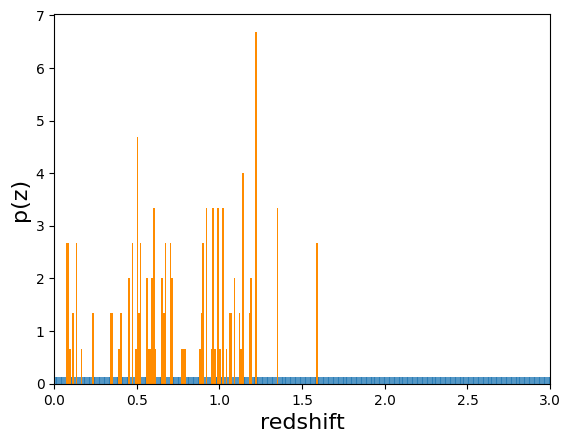

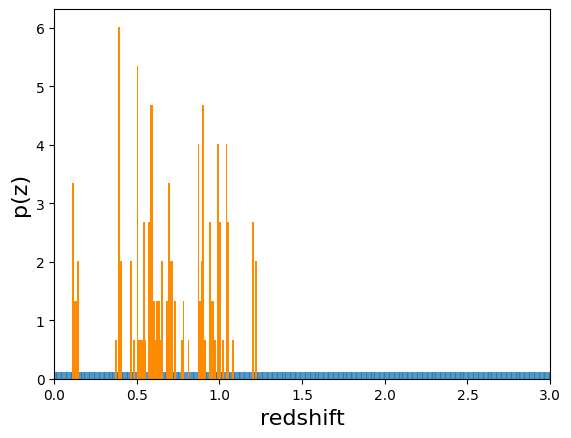

In [27]:
# Plot of naive stack summarized distribution 
point_est_dict_lg[(3,7)]["output"].plot_native(xlim=(0,3))
point_est_dict_lg[(5,10)]["output"].plot_native(xlim=(0,3))

### Large datasets

If the code is slow because you're using extremely large datasets, or you're running into memory issues for the same reason, then we suggest using a pipeline. Pipelines are ideal for large datasets, as the code will chunk up large files and iterate through them as needed. 